The point of this first section is to make a histogram of tweet frequency from 8-830pm for the sep 16 GOP debate. 
<br />
Code is presented for both Spark SQL and Pandas.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# get rid of gridlines 
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

import json
from dateutil import parser, tz
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import re
fname = 'search-terms.txt' # change path to search-terms.txt as needed
f = open(fname,'r')
p = '|(\s|#|@)'.join([line.rstrip() for line in f.readlines()])
f.close()

from pyspark.sql import SQLContext, Row
import pyspark.sql.functions as sqlfunc

In [13]:
def make_json(tweet):
    ''' Get stringified JSOn from Kafka, attempt to convert to JSON '''
    try:
        return json.loads(tweet.decode('utf-8'))
    except:
        return "error"+str(tweet.decode('utf-8'))

def filter_tweets(item,pattern):
    ''' Filters out the tweets we do not want.  Filters include:
            * No retweets 
            * No geolocation or location field (do we really care about this?)
            * English language only
            * No tweets with links
                - We need to check both entities and media fields for this (is that true?)
    '''
    return (('delete' not in item.keys()) and
            ('retweeted_status' not in item.keys())                           and 
            (item['lang']=='en')                       and
            (len(item['entities']['urls'])==0)                   and
            ('media' not in item['entities'].keys()) and
            (re.search(pattern,item['text'],re.I) is not None)
           )

def get_relevant_fields(item):
    ''' Reduce the full set of metadata down to only those we care about, including:
            * timestamp
            * username
            * text of tweet 
            * hashtags
            * geotag coordinates (if any)
            * location (user-defined in profile, not necessarily current location)
    '''
    return (item['id'], 
            {"timestamp":  item['created_at'],
             "username":    item['user']['screen_name'],
             "text":        item['text'],
             "hashtags":    [el['text'] for el in item['entities']['hashtags']],
             "geotag":    item['geo'],
             "user_loc":    item['user']['location']
            }
           )


def update_tz(d,dtype):
    
    def convert_timezone(item):
        from_zone = tz.gettz('UTC')
        to_zone = tz.gettz('America/New_York')
        dt = parser.parse(item['timestamp'])
        utc = dt.replace(tzinfo=from_zone)
        return utc.astimezone(to_zone)
    
    if dtype == "sql":
        return Row(id=d[0], time=convert_timezone(d[1]))
    elif dtype == "pandas":
        return convert_timezone(d[1])

In [3]:
n_parts  = 10
rdd      = sc.textFile('data/*.gz').repartition(n_parts).cache() # partitionBy fails here, need to use repartition()
filtered = (rdd.map(make_json)
               .filter( lambda x: filter_tweets(x,p) )
               .map( get_relevant_fields, preservesPartitioning=True )
            )

Below we demonstrate the syntax differences between using Spark SQL Data Frames and Pandas Data Frames

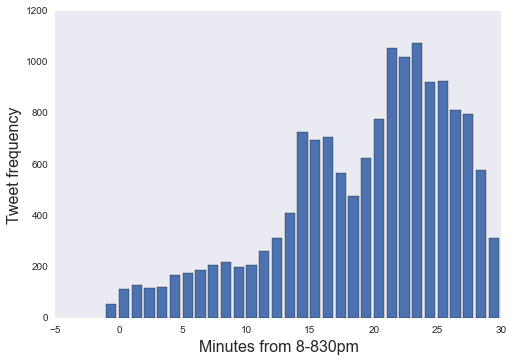

In [14]:
# SparkSQL 

data = filtered.map( lambda x: update_tz(x,'sql'), preservesPartitioning=True )
df = sqlContext.createDataFrame(data).cache()
counts = df.groupby(sqlfunc.minute("time")).count().collect()
minutes,cts = zip(*counts)
minutes = [m if m<59 else -1 for m in minutes] # for some reason 7:59 tweets get included in the 8-815 range

plt.bar(minutes,cts)
plt.xlabel("Minutes from 8-830pm", fontsize=16)
_=plt.ylabel("Tweet frequency", fontsize=16)

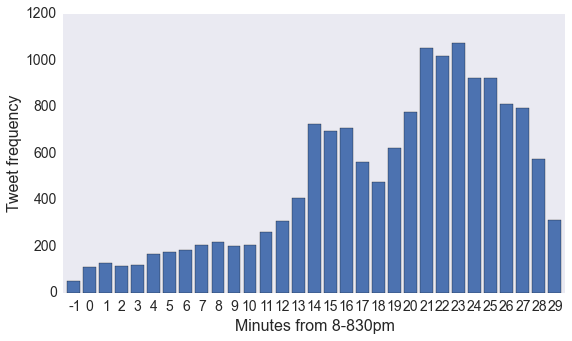

In [16]:
# Pandas

data   = filtered.map( lambda x: update_tz(x,'pandas'), preservesPartitioning=True )
df     = pd.DataFrame(data.collect(),columns=['time'])
counts = df.time.groupby(df.time.dt.minute).count()

np.put( counts.index.values, np.where(counts.index==59)[0],-1) # for some reason 7:59 tweets included in 8-815 range
ax = counts.sort_index().plot(kind='bar',
                              figsize=(9,5),
                              width=.8,
                              fontsize=14,
                              rot=0)
ax.set_ylabel("Tweet frequency",fontsize=16)
_=ax.set_xlabel("Minutes from 8-830pm",fontsize=16)